In [1]:
import warnings
warnings.filterwarnings('ignore')

# for some basic operations
import numpy as np
import scipy as sp
import pandas as pd 
import joypy
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
import wittgenstein as lw
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import pickle
from pyzipcode import ZipCodeDatabase
from math import ceil

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import plotting
from pandas.plotting import parallel_coordinates
from pandas_profiling import ProfileReport

# for interactive visualizations
import plotly
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff
import plotly.io as pio

# for animated visualizations
from bubbly.bubbly import bubbleplot
import plotly_express as px

# for providing path
import os
print(os.getcwd())

# for modelling
import sklearn
import imblearn

# for model explanation
import shap 
import eli5

/Users/mac/Desktop/STAT 8051/Final Project


### Some helper functions

In [2]:
def load_data(path):
    df = pd.read_csv(path, parse_dates = ['claim_date']).drop(['claim_number'], axis = 1)
    return df

In [3]:
def get_week_of_month(date):
    first_day = date.replace(day=1)
    
    day_of_month = date.day

    if(first_day.weekday() == 6):
        adjusted_dom = (1 + first_day.weekday()) / 7
    else:
        adjusted_dom = day_of_month + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [4]:
def check_nulls(df):
    return df.isnull().sum()[df.isnull().sum() > 0]

In [5]:
def generate_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    plt.rcParams['figure.figsize'] = (10, 5)
    cm = confusion_matrix(y_true, y_pred)
    g = sns.heatmap(cm, annot = True, cmap = 'spring', fmt = '.4g')
    return g

In [6]:
def is_married(x):
    if x == 1.0:
        return True
    elif x == 0.0:
        return False
    else:
        return x

In [7]:
def get_weekend(x):
    if(x == 'Saturday' or x == 'Sunday'):
        return 1
    else:
        return 0

In [8]:
def replace_income(df):
    df.loc[df[df['annual_income'] <= 0].index, 'annual_income'] = np.nan
    return df

In [9]:
def one_hot(col, encoder, df):
    mask = ~df[col].isnull()
    df[col][mask] = encoder.fit_transform(df[col][mask])
    return df

In [10]:
def encode(col, le, df):
    mask = ~df[col].isnull()
    df[col][mask] = le.fit_transform(df[col][mask])
    return df

In [11]:
def get_zip_codes(x, zip_code_engine):
    try:
        return zip_code_engine[x].city
    except:
        return 'None'

In [12]:
def feat_and_tar(df, target):
    X = df.drop(target, axis = 1)
    y = df[target]
    return X, y

In [13]:
def split_dataset(X, y, test_size = .3):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = .3,
                                       stratify = y,
                                       random_state = 1)
    return X_train, X_test, y_train, y_test

In [14]:
def knn_impute(imp, X):
    imp.fit(X)
    return imp

In [15]:
def simple_impute(X, imp, num_cols, cat_cols):
    imp[0].fit(X[num_cols])
    imp[1].fit(X[cat_cols])
    return imp

In [16]:
def scale(ss, X):
    ss.fit(X)
    return ss

In [17]:
def generate_subm_csv(claim_id, y_out, name_initials):
    df = pd.DataFrame({'claim_number' : claim_id,
                       'pred' : y_out})
    
    df.to_csv(f"travellers_final_submission_{name_initials}.csv",
              index = False)
    return df

### Some default conditions

In [18]:
pd.set_option('display.max_columns', None)
plt.figure(figsize = (10, 8))
sns.set_style('darkgrid')
%matplotlib inline

## Reading the data..

In [19]:
df = load_data('train_2021.csv')

In [20]:
df.head()

age_of_driver gender  marital_status  safty_rating  annual_income  \
0             46      M             1.0            85          38301   
1             21      F             0.0            75          30445   
2             49      F             0.0            87          38923   
3             58      F             1.0            58          40605   
4             38      M             1.0            95          36380   

   high_education_ind  address_change_ind living_status  zip_code claim_date  \
0                   1                   1          Rent     80006 2016-12-16   
1                   0                   1          Rent     15021 2015-02-12   
2                   0                   1           Own     20158 2016-12-06   
3                   1                   0           Own     15024 2016-05-05   
4                   1                   0          Rent     50034 2015-10-27   

  claim_day_of_week accident_site  past_num_of_claims  witness_present_ind  \
0            Friday         Local                   1                  0.0   
1          Thursday       Highway                   1                  1.0   
2           Tuesday         Local                   0                  0.0   
3          Thursday         Local                   3                  0.0   
4           Tuesday       Highway                   0                  1.0   

   liab_prct channel  policy_report_filed_ind  claim_est_payout  \
0         74  Broker                        0       7530.940993   
1         79  Online                        0       2966.024895   
2          0  Broker                        0       6283.888333   
3         99  Broker                        1       6169.747994   
4          7  Broker                        0       4541.387150   

   age_of_vehicle vehicle_category  vehicle_price vehicle_color  \
0             9.0          Compact    12885.45235         white   
1             4.0            Large    29429.45218         white   
2             3.0          Compact    21701.18195         white   
3             4.0           Medium    13198.27344         other   
4             7.0           Medium    38060.21122          gray   

   vehicle_weight  fraud  
0     16161.33381      0  
1     28691.96422      0  
2     22090.94758      1  
3     38329.58106      1  
4     25876.56319      0

In [21]:
df.shape

(17998, 24)

## EDA

### Check missing values

In [22]:
check_nulls(df)

marital_status           5
witness_present_ind    132
claim_est_payout        17
age_of_vehicle           8
dtype: int64

### Missing data in above mentioned columns

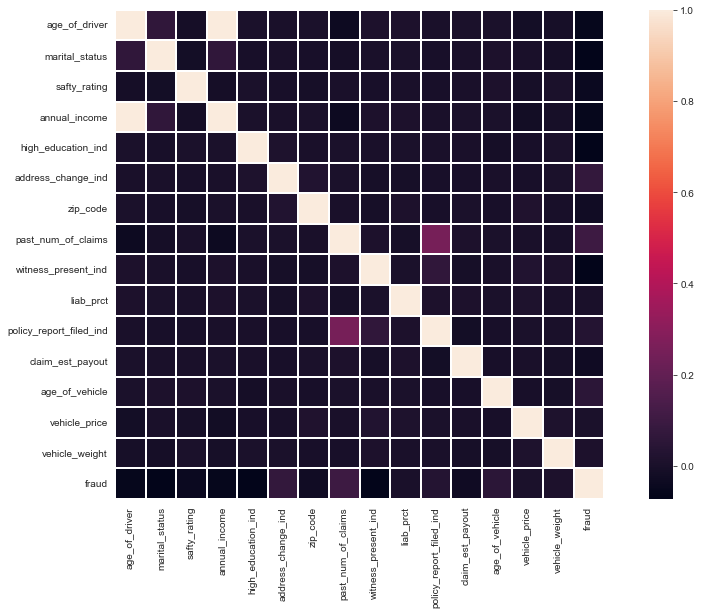

In [23]:
plt.figure(figsize = (16, 9))
sns.heatmap(df.corr('spearman'), robust = True,
            square = True, linewidths = 1.5);

In [24]:
df.corr().iloc[:, -1].sort_values(ascending = False)[1:]

past_num_of_claims         0.118596
address_change_ind         0.072249
age_of_vehicle             0.052197
policy_report_filed_ind    0.030132
vehicle_weight             0.009484
liab_prct                  0.001463
vehicle_price              0.000746
claim_est_payout          -0.016708
zip_code                  -0.032322
annual_income             -0.045646
safty_rating              -0.050729
age_of_driver             -0.059291
witness_present_ind       -0.074150
marital_status            -0.078435
high_education_ind        -0.098350
Name: fraud, dtype: float64

#### Age and income have high correlation; could be used to impute nulls of annual_income
#### Most highly correlated features wrt target are address_change_ind, past_num_of_claims, policy_report_filed_ind & age_of_vehicle

### Lets check the descriptive stats

In [25]:
df.describe()

age_of_driver  marital_status  safty_rating  annual_income  \
count   17998.000000    17993.000000  17998.000000   17998.000000   
mean       43.695466        0.712722     73.562951   37367.655684   
std        11.959819        0.452505     15.346807    2957.297249   
min        18.000000        0.000000      1.000000      -1.000000   
25%        35.000000        0.000000     65.000000   35554.000000   
50%        43.000000        1.000000     76.000000   37610.000000   
75%        51.000000        1.000000     85.000000   39318.000000   
max       229.000000        1.000000    100.000000   54333.000000   

       high_education_ind  address_change_ind      zip_code  \
count        17998.000000        17998.000000  17998.000000   
mean             0.699189            0.577286  49875.595955   
std              0.458623            0.494004  29214.655149   
min              0.000000            0.000000      0.000000   
25%              0.000000            0.000000  20111.000000   
50%              1.000000            1.000000  50028.000000   
75%              1.000000            1.000000  80038.000000   
max              1.000000            1.000000  85083.000000   

       past_num_of_claims  witness_present_ind     liab_prct  \
count        17998.000000         17866.000000  17998.000000   
mean             0.505001             0.232677     49.423269   
std              0.955504             0.422550     33.678470   
min              0.000000             0.000000      0.000000   
25%              0.000000             0.000000     17.000000   
50%              0.000000             0.000000     50.000000   
75%              1.000000             0.000000     81.000000   
max              6.000000             1.000000    100.000000   

       policy_report_filed_ind  claim_est_payout  age_of_vehicle  \
count             17998.000000      17981.000000    17990.000000   
mean                  0.600678       4975.792083        5.008060   
std                   0.489773       2215.706510        2.258391   
min                   0.000000        282.639432        0.000000   
25%                   0.000000       3337.029436        3.000000   
50%                   1.000000       4668.796318        5.000000   
75%                   1.000000       6255.901066        6.000000   
max                   1.000000      17218.345010       16.000000   

       vehicle_price  vehicle_weight         fraud  
count   17998.000000    17998.000000  17998.000000  
mean    23089.123114    23031.322385      0.156462  
std     11988.429767    12052.385584      0.363303  
min      2457.329316     2429.429302      0.000000  
25%     14279.574850    14164.122133      0.000000  
50%     20948.879250    20838.150260      0.000000  
75%     29562.232780    29430.446293      0.000000  
max    127063.506000   123016.650400      1.000000

#### Avg liab_prct is 50%
#### Avg age of clients is 43
#### Most of them are married
#### Most of them have higher education
#### almost 70%of the clients have had no past claims
#### in most of the cases, witnesses were not present
#### avg age of vehicle is 5 yrs

### Lets check the skewness of the target

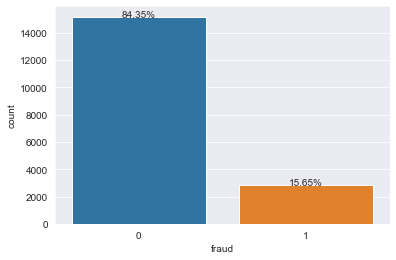

In [26]:
ax = sns.countplot(data = df, x = 'fraud')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/df.shape[0]*100), (p.get_x()+0.30, p.get_height()+1))

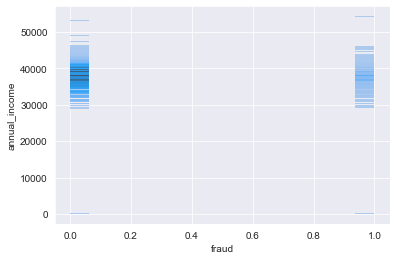

In [27]:
sns.histplot(data = df, x = 'fraud', y = 'annual_income');

### Analysing the date feature

In [28]:
frauds = df[df['fraud'] == 1]

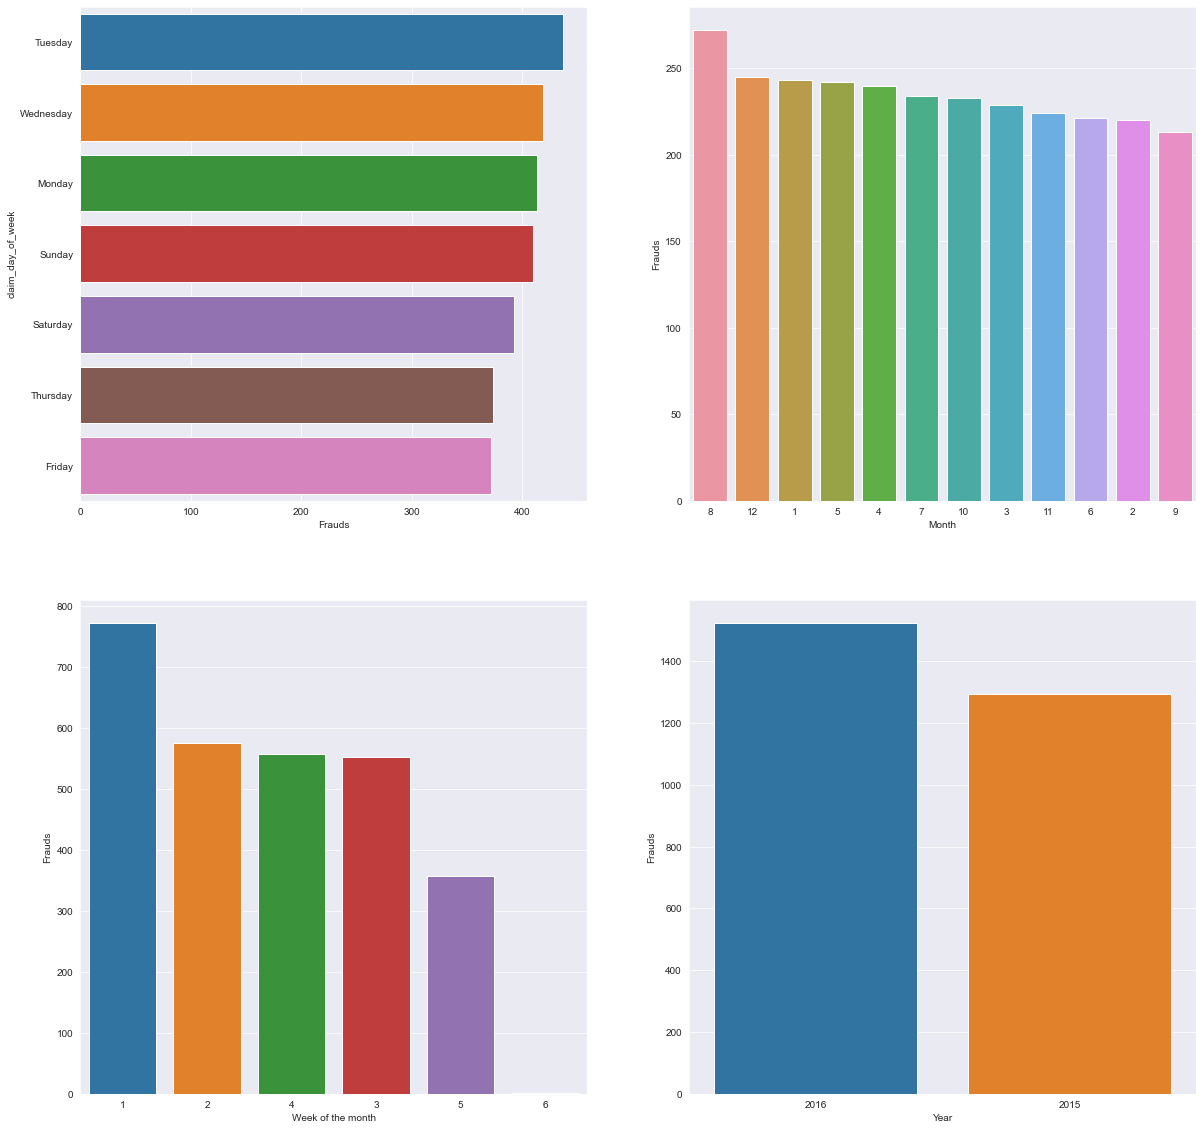

In [29]:
fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax = ax.ravel()

sns.countplot(y = frauds['claim_day_of_week'], ax = ax[0],
              order = frauds['claim_day_of_week'].value_counts().index);
ax[0].set_xlabel('Frauds');

sns.countplot(frauds['claim_date'].dt.month, ax = ax[1],
              order = frauds['claim_date'].dt.month.value_counts().index);
ax[1].set_xlabel('Month');
ax[1].set_ylabel('Frauds');

sns.countplot(frauds['claim_date'].map(lambda x : get_week_of_month(x)), ax = ax[2],
              order = frauds['claim_date'].map(lambda x : get_week_of_month(x)).value_counts().index);
ax[2].set_xlabel('Week of the month');
ax[2].set_ylabel('Frauds');

sns.countplot(frauds['claim_date'].dt.year, ax = ax[3],
              order = frauds['claim_date'].dt.year.value_counts().index);
ax[3].set_xlabel('Year');
ax[3].set_ylabel('Frauds');

## Feature Engineering of Date Attribute

In [30]:
df['year'] = df['claim_date'].dt.year
df['month'] = df['claim_date'].dt.month

In [31]:
df['is_weekend'] = df['claim_day_of_week'].map(lambda x : get_weekend(x))

In [32]:
df['is_month_end'] = df['claim_date'].map(lambda x : x.is_month_end)

In [33]:
df['is_month_start'] = df['claim_date'].map(lambda x : x.is_month_start)

## Preprocessing

### Setting the values of income less than 0 as NaN

In [34]:
df = replace_income(df)

In [35]:
check_nulls(df)

marital_status           5
annual_income           15
witness_present_ind    132
claim_est_payout        17
age_of_vehicle           8
dtype: int64

## Changing marital status to categorical

In [36]:
df['marital_status'] = df['marital_status'].map(lambda x : is_married(x))

## Searching cities from zipcodes

In [37]:
zcdb = ZipCodeDatabase()

In [38]:
df['city'] = df['zip_code'].map(lambda x : get_zip_codes(x, zcdb))

In [39]:
df['city'].value_counts()['None']

167

In [40]:
most_freq_city = df['city'].mode().values[0]

In [41]:
df['city'].replace({'None' : np.nan}, inplace = True)

## Target Encoding of the cities

In [42]:
target_enc = df[['city','fraud']].groupby(['city'], 
                as_index = False).mean().sort_values(by = 'fraud', 
                                                     ascending = False)
target_embeddings = target_enc.set_index('city').T.to_dict('list')

In [43]:
df['city'].replace(target_embeddings, inplace = True)

In [44]:
df.drop('zip_code', axis = 1, inplace = True)

### Dropping unnecessary and correlated features

In [45]:
df.drop('claim_date', axis = 1, inplace = True)

### Selecting categroical and numerical columns

In [46]:
num_cols = df.drop('fraud', axis = 1).select_dtypes(include = ['number']).columns.tolist()
cat_cols = df.drop('fraud', axis = 1).select_dtypes(include = ['O']).columns.tolist()

### Imputing Annual Income with Age of Driver and rest attributes using KNN Imputer(Do not run the other 2 imputations while using this)

In [47]:
x_imp_train = df[df['annual_income'].notna()][['age_of_driver']]
y_imp_train = df[df['annual_income'].notna()]['annual_income']

In [48]:
x_imp_test = df[df['annual_income'].isnull()][['age_of_driver']]

In [49]:
dtc_imp = DecisionTreeClassifier(random_state = 1)
dtc_imp.fit(x_imp_train, y_imp_train)
pred_values = dtc_imp.predict(x_imp_test)

In [50]:
nan_index = df[df['annual_income'].isnull()]['annual_income'].index
df.loc[nan_index, 'annual_income'] = pred_values

In [51]:
df['annual_income'].isnull().sum()

0

### Dropping highly correlated variables

In [52]:
df.drop('age_of_driver', axis = 1, inplace = True)

### Transforming skewed attributes

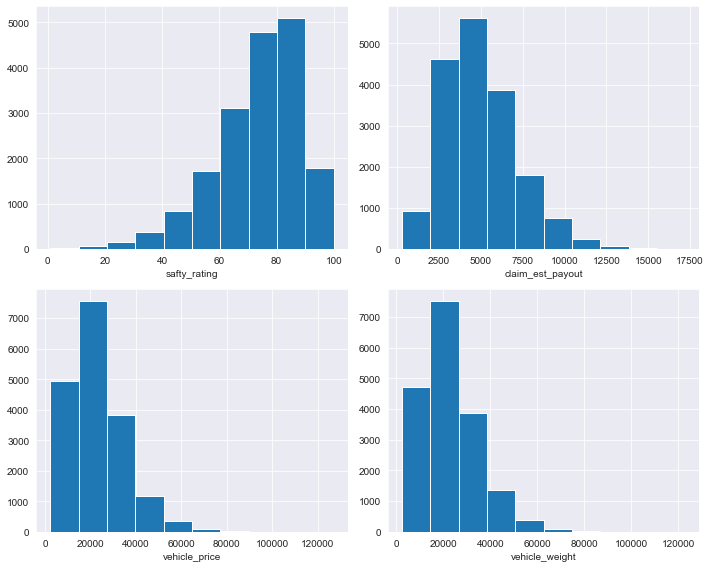

In [53]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))

cols = ['safty_rating', 'claim_est_payout', 'vehicle_price', 'vehicle_weight']


for idx, ax in enumerate(axs.ravel()):
    ax.hist(df[cols[idx]])
    ax.set_xlabel(cols[idx])

plt.tight_layout()

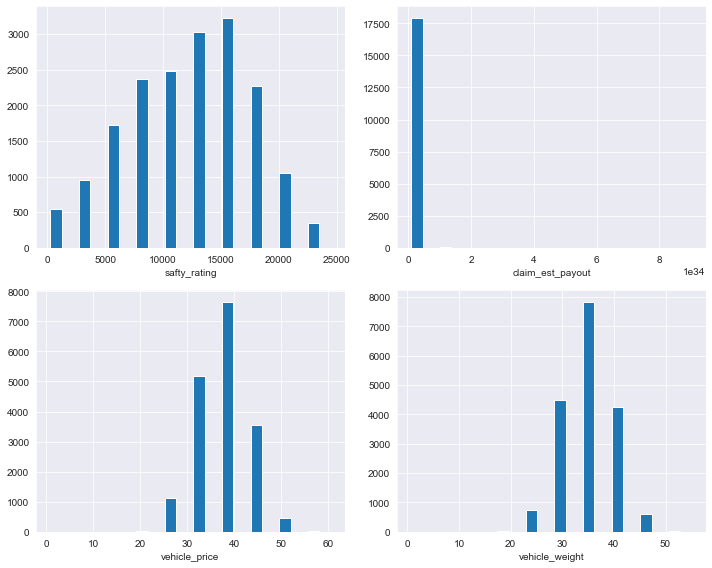

In [54]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))

cols = ['safty_rating', 'claim_est_payout', 'vehicle_price', 'vehicle_weight']


for idx, ax in enumerate(axs.ravel()):
    ax.hist(sp.stats.boxcox(df[cols[idx]]))
    ax.set_xlabel(cols[idx])

plt.tight_layout()

In [55]:
for i in cols:
    df[i] = sp.stats.boxcox(df[i])[0]

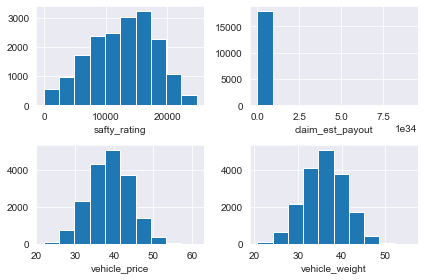

In [56]:
fig, axs = plt.subplots(2, 2)

cols = ['safty_rating', 'claim_est_payout', 'vehicle_price', 'vehicle_weight']


for idx, ax in enumerate(axs.ravel()):
    ax.hist(df[cols[idx]])
    ax.set_xlabel(cols[idx])

plt.tight_layout()

### One hot encoding(Dont run the encoding cell below if this has been executed)

In [57]:
df = pd.get_dummies(df, drop_first = True,
                         columns = ['gender', 'marital_status', 'high_education_ind',
                                    'address_change_ind', 'living_status',
                                    'claim_day_of_week', 'accident_site',
                                    'witness_present_ind', 'channel', 
                                    'policy_report_filed_ind', 'vehicle_category',
                                    'vehicle_color', 'year', 'month', 'is_weekend',
                                    'is_month_start', 'is_month_end'])

In [58]:
df.shape

(17998, 50)

### Imputing nulls using KNN imputer

In [59]:
imp = KNNImputer()
df = pd.DataFrame(imp.fit_transform(df),columns = df.columns)

### Dividing initial the dataframe into features and response

In [60]:
X, y = feat_and_tar(df, 'fraud')

### 70:30 Train test split with stratification of response

In [61]:
X_train, X_test, y_train, y_test = split_dataset(X, y)

### Standardizing the features

In [62]:
ss = StandardScaler()

In [63]:
ss = scale(ss, X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [64]:
print("Shape of X_train:", X_train_scaled.shape)
print("Shape of X_test:", X_test_scaled.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (12598, 49)
Shape of X_test: (5400, 49)
Shape of y_train: (12598,)
Shape of y_test: (5400,)


### Sampling

In [65]:
over_sm = SMOTE()

In [66]:
X_train_over, y_train_over = over_sm.fit_resample(X_train_scaled, y_train)

In [67]:
y_train.value_counts(), y_train_over.value_counts()

(0.0    10627
 1.0     1971
 Name: fraud, dtype: int64,
 0.0    10627
 1.0    10627
 Name: fraud, dtype: int64)

In [68]:
under_sm = RandomUnderSampler()

In [69]:
X_train_under, y_train_under = under_sm.fit_resample(X_train_scaled, y_train)

In [70]:
y_train.value_counts(), y_train_under.value_counts()

(0.0    10627
 1.0     1971
 Name: fraud, dtype: int64,
 0.0    1971
 1.0    1971
 Name: fraud, dtype: int64)

## Model Building

### Applying Logistic Regression (no sampling)

In [71]:
log_lr = LogisticRegression(penalty = 'none', random_state = 1)

In [72]:
log_lr.fit(X_train_scaled, y_train)

LogisticRegression(penalty='none', random_state=1)

In [73]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [74]:
cv_scores = cross_val_score(log_lr, X_train_scaled, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [75]:
print("LogLr:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

LogLr: [0.08200456 0.06818182 0.02717391 0.07095344 0.04807692 0.03294118
 0.04275534 0.06341463 0.08450704 0.05687204 0.06763285 0.03414634
 0.04618938 0.04576659 0.05405405]
Mean(F1): 0.0549780063141743
Std dev(F1): 0.01696952664922913


In [76]:
y_pred = log_lr.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91      4555
         1.0       0.50      0.03      0.05       845

    accuracy                           0.84      5400
   macro avg       0.67      0.51      0.48      5400
weighted avg       0.79      0.84      0.78      5400



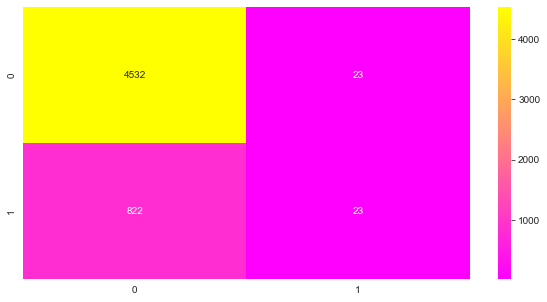

In [77]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [78]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.5
Recall is: 0.03
F-score is: 0.05


### Applying Logistic Regression (oversampling)

In [79]:
log_lr = LogisticRegression(penalty = 'none', random_state = 1)

In [80]:
log_lr.fit(X_train_over, y_train_over)

LogisticRegression(penalty='none', random_state=1)

In [81]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [82]:
cv_scores = cross_val_score(log_lr, X_train_over, y_train_over, scoring='f1', cv=cv, n_jobs=-1)

In [83]:
print("LogLr:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

LogLr: [0.67221067 0.67585573 0.66621036 0.67565056 0.66387727 0.66247379
 0.66464411 0.67741193 0.67153285 0.68031854 0.67894979 0.67349261
 0.67262314 0.66620079 0.66775548]
Mean(F1): 0.6712805078178824
Std dev(F1): 0.005574327911164956


In [84]:
y_pred = log_lr.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.91      0.66      0.77      4555
         1.0       0.26      0.65      0.37       845

    accuracy                           0.66      5400
   macro avg       0.59      0.66      0.57      5400
weighted avg       0.81      0.66      0.70      5400



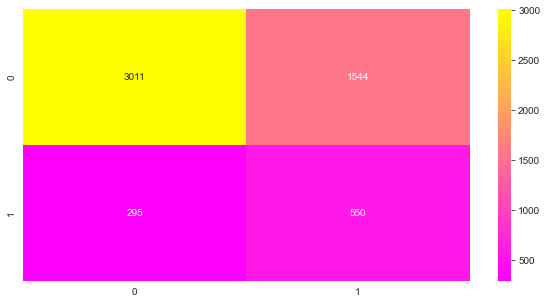

In [85]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [86]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.26
Recall is: 0.65
F-score is: 0.37


### Applying Logistic Regression (undersampling)

In [87]:
log_lr = LogisticRegression(penalty = 'none', random_state = 1)

In [88]:
log_lr.fit(X_train_under, y_train_under)

LogisticRegression(penalty='none', random_state=1)

In [89]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [90]:
cv_scores = cross_val_score(log_lr, X_train_under, y_train_under, scoring='f1', cv=cv, n_jobs=-1)

In [91]:
print("LogLr:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

LogLr: [0.61760841 0.64735516 0.65151515 0.67699642 0.62986198 0.65533981
 0.67435897 0.6343949  0.63024142 0.61616162 0.6525     0.61261261
 0.6460396  0.63567839 0.64885496]
Mean(F1): 0.6419679617515901
Std dev(F1): 0.01871211521096366


In [92]:
y_pred = log_lr.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.91      0.65      0.76      4555
         1.0       0.26      0.67      0.37       845

    accuracy                           0.65      5400
   macro avg       0.59      0.66      0.57      5400
weighted avg       0.81      0.65      0.70      5400



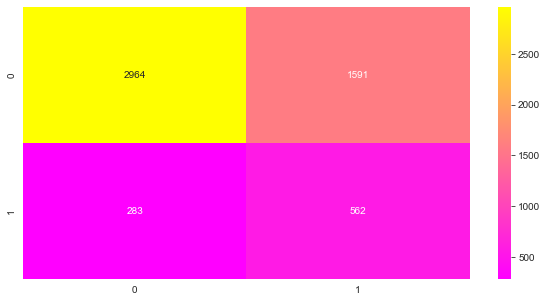

In [93]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [94]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.26
Recall is: 0.67
F-score is: 0.37


### Applying random forest (no sampling)

In [95]:
rfc = RandomForestClassifier(random_state = 1)

In [96]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=1)

In [97]:
cv_scores = cross_val_score(rfc, X_train_scaled, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [98]:
print("RFC:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

RFC: [0.02403846 0.0049505  0.00566572 0.         0.00506329 0.00995025
 0.00501253 0.         0.00511509 0.00496278 0.         0.01025641
 0.         0.00487805 0.        ]
Mean(F1): 0.005326205193242814
Std dev(F1): 0.005991555083497987


In [99]:
y_pred = rfc.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.92      4555
         1.0       0.75      0.01      0.01       845

    accuracy                           0.84      5400
   macro avg       0.80      0.50      0.46      5400
weighted avg       0.83      0.84      0.77      5400



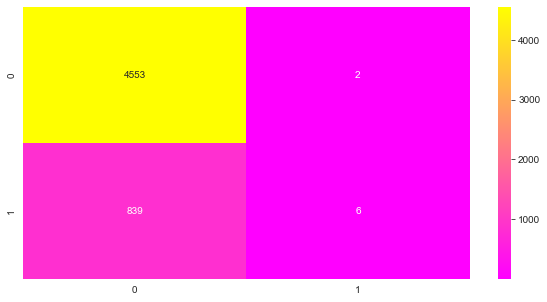

In [100]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [101]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.75
Recall is: 0.01
F-score is: 0.01


### Applying random forest (oversampling)

In [102]:
rfc = RandomForestClassifier(random_state = 1)

In [103]:
rfc.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=1)

In [104]:
cv_scores = cross_val_score(rfc, X_train_over, y_train_over, scoring='f1', cv=cv, n_jobs=-1)

In [105]:
print("RFC:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

RFC: [0.90448442 0.90810811 0.90781914 0.91852227 0.90909091 0.90804598
 0.90825688 0.9138368  0.90872618 0.91572893 0.90959737 0.91223607
 0.90799699 0.91034483 0.90466321]
Mean(F1): 0.9098305382857746
Std dev(F1): 0.003702045711798132


In [106]:
y_pred = rfc.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91      4555
         1.0       0.45      0.04      0.08       845

    accuracy                           0.84      5400
   macro avg       0.65      0.52      0.49      5400
weighted avg       0.79      0.84      0.78      5400



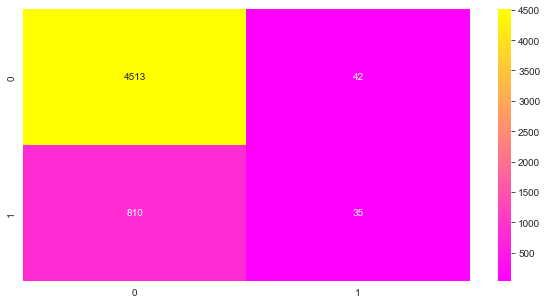

In [107]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [108]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.45
Recall is: 0.04
F-score is: 0.08


### Applying random forest (undersampling)

In [109]:
rfc = RandomForestClassifier(random_state = 1)

In [110]:
rfc.fit(X_train_under, y_train_under)

RandomForestClassifier(random_state=1)

In [111]:
cv_scores = cross_val_score(rfc, X_train_under, y_train_under, scoring='f1', cv=cv, n_jobs=-1)

In [112]:
print("RFC:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

RFC: [0.63544304 0.63265306 0.65675341 0.65517241 0.59324155 0.62709677
 0.6591195  0.64871481 0.64993726 0.63144963 0.65162907 0.63786531
 0.65598027 0.65577889 0.62278481]
Mean(F1): 0.6409079873331507
Std dev(F1): 0.017281898023121623


In [113]:
y_pred = rfc.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.75      4555
         1.0       0.25      0.65      0.36       845

    accuracy                           0.64      5400
   macro avg       0.58      0.64      0.55      5400
weighted avg       0.81      0.64      0.69      5400



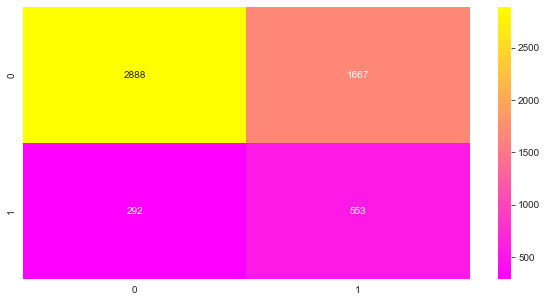

In [114]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [115]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.25
Recall is: 0.65
F-score is: 0.36


### Adaptive Boosting (no sampling)

In [116]:
adac = AdaBoostClassifier(random_state = 1)

In [117]:
adac.fit(X_train_scaled, y_train)

AdaBoostClassifier(random_state=1)

In [118]:
cv_scores = cross_val_score(adac, X_train_scaled, y_train, scoring='f1', cv=cv, n_jobs=-1)

In [119]:
print("ADAC:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

ADAC: [0.12631579 0.1038961  0.14111922 0.1242236  0.09545455 0.08636364
 0.09799555 0.11790393 0.12888889 0.13596491 0.12053571 0.10799136
 0.12147505 0.10989011 0.13242009]
Mean(F1): 0.1166959004308233
Std dev(F1): 0.015403099719295774


In [120]:
y_pred = rfc.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.75      4555
         1.0       0.25      0.65      0.36       845

    accuracy                           0.64      5400
   macro avg       0.58      0.64      0.55      5400
weighted avg       0.81      0.64      0.69      5400



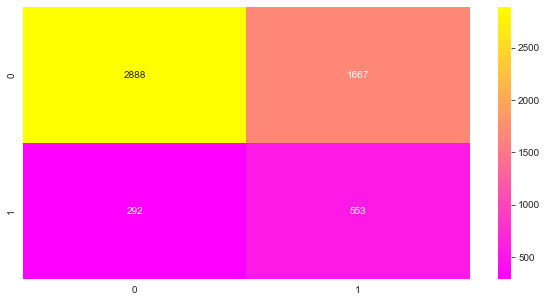

In [121]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [122]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.25
Recall is: 0.65
F-score is: 0.36


### Adaptive Boosting (oversampling)

In [123]:
ada = AdaBoostClassifier(random_state = 1)

In [124]:
ada.fit(X_train_over, y_train_over)

AdaBoostClassifier(random_state=1)

In [125]:
cv_scores = cross_val_score(ada, X_train_over, y_train_over, scoring='f1', cv=cv, n_jobs=-1)

In [126]:
print("ADAC:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

ADAC: [0.86717407 0.87868852 0.87384765 0.88233849 0.86914947 0.87018618
 0.87546607 0.87978142 0.86978008 0.88204876 0.87204969 0.88194444
 0.87850467 0.87434161 0.87310415]
Mean(F1): 0.875227018587765
Std dev(F1): 0.0048983810102087855


In [127]:
y_pred = ada.predict(X_test_scaled)

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      4555
         1.0       0.38      0.23      0.29       845

    accuracy                           0.82      5400
   macro avg       0.62      0.58      0.59      5400
weighted avg       0.79      0.82      0.80      5400



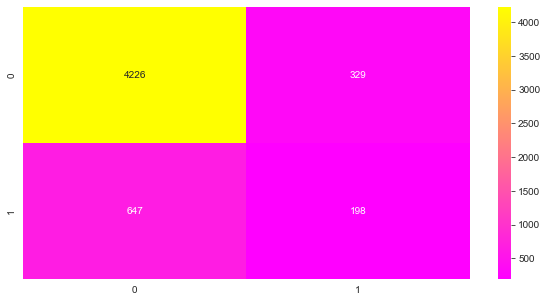

In [128]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [129]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.38
Recall is: 0.23
F-score is: 0.29


### Adaptive Boosting (undersampling)

In [130]:
ada = AdaBoostClassifier(random_state = 1)

In [131]:
ada.fit(X_train_under, y_train_under)

AdaBoostClassifier(random_state=1)

In [132]:
cv_scores = cross_val_score(rfc, X_train_under, y_train_under, scoring='f1', cv=cv, n_jobs=-1)

In [133]:
print("RFC:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

RFC: [0.63544304 0.63265306 0.65675341 0.65517241 0.59324155 0.62709677
 0.6591195  0.64871481 0.64993726 0.63144963 0.65162907 0.63786531
 0.65598027 0.65577889 0.62278481]
Mean(F1): 0.6409079873331507
Std dev(F1): 0.017281898023121623


In [134]:
y_pred = rfc.predict(X_test_scaled)

### Confusion matrix

              precision    recall  f1-score   support

         0.0       0.91      0.63      0.75      4555
         1.0       0.25      0.65      0.36       845

    accuracy                           0.64      5400
   macro avg       0.58      0.64      0.55      5400
weighted avg       0.81      0.64      0.69      5400



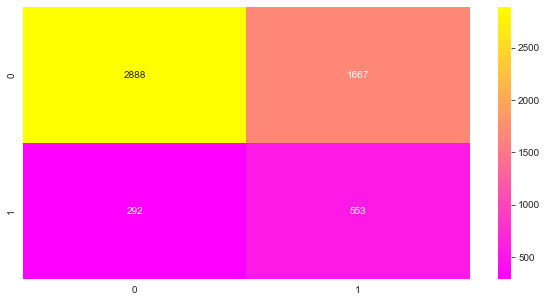

In [135]:
generate_classification_report(y_test, y_pred);

### Performance metrics

In [136]:
print("Precision is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[0], 2))
print("Recall is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[1], 2))
print("F-score is:", round(precision_recall_fscore_support(y_test, y_pred, average='binary')[2], 2))

Precision is: 0.25
Recall is: 0.65
F-score is: 0.36


## Best flow : Mixed imputation + undersampling + (Logistic+forest+boost)

### Stacking classifier using the top 3 models

In [137]:
vc = VotingClassifier(estimators = [('logistic', log_lr), ('adaboost', ada),
                                   ('forest', rfc)],
                      voting = 'hard')

In [138]:
vc.fit(X_train_under, y_train_under)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(penalty='none',
                                                 random_state=1)),
                             ('adaboost', AdaBoostClassifier(random_state=1)),
                             ('forest',
                              RandomForestClassifier(random_state=1))])

In [139]:
cv_scores = cross_val_score(vc, X_train_under, y_train_under, scoring='f1', cv=cv, n_jobs=-1)

In [140]:
print("VC:",cv_scores)
print("Mean(F1):", np.mean(cv_scores))
print("Std dev(F1):", np.std(cv_scores))

VC: [0.64774194 0.6443299  0.67990074 0.67865707 0.62311558 0.65829146
 0.68015171 0.65667915 0.65463918 0.62562814 0.6566416  0.62193548
 0.66502463 0.65903308 0.66582915]
Mean(F1): 0.654506586871939
Std dev(F1): 0.01861591379772247


In [141]:
y_pred = vc.predict(X_test_scaled)

              precision    recall  f1-score   support

         0.0       0.92      0.66      0.77      4555
         1.0       0.27      0.68      0.39       845

    accuracy                           0.67      5400
   macro avg       0.60      0.67      0.58      5400
weighted avg       0.82      0.67      0.71      5400



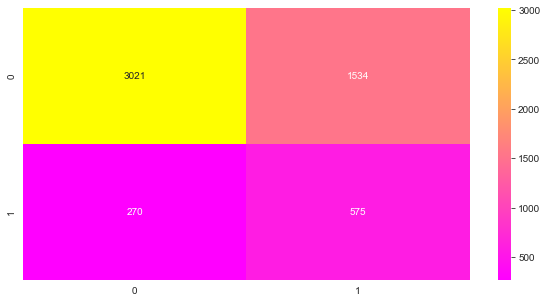

In [142]:
generate_classification_report(y_test, y_pred);

## Feature Importance using Random forest (mean decrease in impurity)

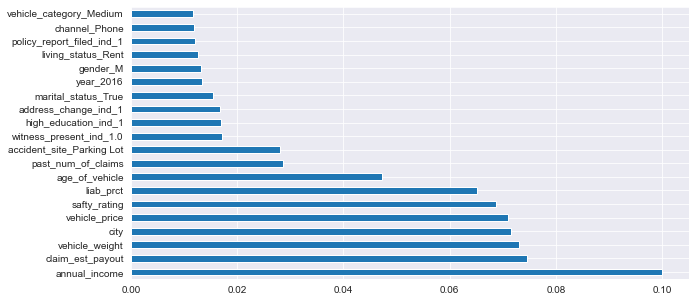

In [143]:
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh');

## Feature Importance using Random forest (permutation importance)

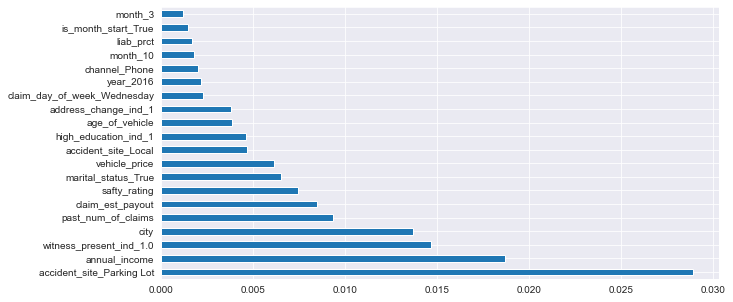

In [146]:
result = permutation_importance(
    rfc, X_test_scaled, y_test, n_repeats=10, random_state=1, n_jobs=2)
feat_importances = pd.Series(result.importances_mean, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh');